In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [8]:
data = pd.read_csv("data_without_labels.csv")

In [9]:
data['Elevation'] = data['Elevation']**4

In [10]:
from sklearn.preprocessing import StandardScaler

for col in list(data):
    print(col)
    if col != "Observation_ID" and col != "Labels":
        data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1, 1))
display(data.describe())

Observation_ID
Elevation
Aspect
Slope
Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Hillshade_9am
Hillshade_Noon
Hillshade_3pm
Horizontal_Distance_To_Fire_Points
Labels


C:\Users\chali\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Observation_ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Labels
count,286048.000000,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,2.860480e+05,286048.000000
mean,143024.500000,3.815421e-17,9.538553e-17,6.359036e-17,4.292349e-17,5.325692e-17,7.948794e-17,9.618041e-17,-1.430783e-17,2.018994e-16,3.497470e-17,0.009603
std,82575.089238,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.097525
min,1.000000,-3.054586e+00,-1.413336e+00,-1.904938e+00,-1.322143e+00,-3.805600e+00,-1.492490e+00,-8.574477e+00,-1.214145e+01,-3.908895e+00,-1.513780e+00,0.000000
25%,71512.750000,-7.140144e-01,-8.551365e-01,-7.842469e-01,-7.519574e-01,-6.580200e-01,-7.984605e-01,-5.202654e-01,-5.523217e-01,-6.213487e-01,-6.956474e-01,0.000000
50%,143024.500000,-4.298931e-03,-2.411166e-01,-8.381491e-02,-1.817717e-01,-2.754412e-01,-2.465743e-01,2.010073e-01,9.451305e-02,-1.863195e-02,-2.272400e-01,0.000000
75%,214536.250000,5.974050e-01,8.287667e-01,6.166171e-01,5.309606e-01,3.679867e-01,6.001045e-01,7.219265e-01,7.413478e-01,6.662735e-01,3.451019e-01,0.000000
max,286048.000000,3.386190e+00,1.935863e+00,7.340764e+00,5.315770e+00,9.654217e+00,2.905913e+00,1.603482e+00,1.549891e+00,3.049744e+00,3.523531e+00,1.000000


In [11]:
minor = data[data['Labels'] == 1]
normal = data[data['Labels'] == 0]
print("shape of minor: ", minor.shape)
print("shape of normal: ", normal.shape)

shape of minor:  (2747, 12)
shape of normal:  (283301, 12)


In [12]:
display(minor.describe())

,Observation_ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Labels
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2747.0
mean,37259.008009,-2.576355,-0.137483,0.690714,-0.814037,-0.080904,-0.927502,0.575501,-0.444673,-0.857154,-0.910452,1.0
std,67177.616826,0.235604,0.809361,1.309497,0.663968,1.026927,0.226372,0.967413,1.127506,1.349657,0.337690,0.0
min,826.000000,-3.054586,-1.413336,-1.904938,-1.322143,-1.231888,-1.451083,-3.485498,-4.756748,-3.908895,-1.513780,1.0
25%,1612.500000,-2.770797,-0.636508,-0.363988,-1.322143,-0.797140,-1.106849,0.040724,-1.145254,-1.881575,-1.186527,1.0
50%,2327.000000,-2.576292,-0.306240,0.756703,-1.179597,-0.692800,-0.905995,0.842139,-0.282807,-0.813122,-0.947759,1.0
75%,4004.500000,-2.398387,0.065893,1.737308,-0.409846,0.454936,-0.739749,1.403128,0.310125,0.173142,-0.637360,1.0
max,177194.000000,-1.743551,1.926560,4.539036,1.295960,3.898145,-0.440631,1.603482,1.549891,2.447028,-0.164739,1.0


In [13]:
display(normal.describe())

,Observation_ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Labels
count,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.000000,283301.0
mean,144050.044585,0.024981,0.001333,-0.006697,0.007893,0.000784,0.008993,-0.005580,0.004312,0.008311,0.008828,0.0
std,82045.719592,0.971688,1.001581,0.994187,0.999469,0.999707,1.000390,0.998692,0.997718,0.992396,1.000240,0.0
min,1.000000,-2.770797,-1.413336,-1.904938,-1.322143,-3.805600,-1.492490,-8.574477,-12.141445,-3.908895,-1.513780,0.0
25%,72986.000000,-0.686753,-0.855137,-0.784247,-0.751957,-0.658020,-0.789190,-0.520265,-0.552322,-0.621349,-0.690029,0.0
50%,143811.000000,0.006258,-0.231813,-0.083815,-0.181772,-0.275441,-0.232360,0.201007,0.094513,-0.018632,-0.217408,0.0
75%,215223.000000,0.603285,0.828767,0.616617,0.535712,0.350597,0.613701,0.721926,0.741348,0.666273,0.351422,0.0
max,286048.000000,3.386190,1.935863,7.340764,5.315770,9.654217,2.905913,1.603482,1.549891,3.049744,3.523531,0.0


In [14]:
labels = data['Labels']
del data['Labels']
del data['Observation_ID']
X_train = data.values
print(X_train.shape)
print(labels.shape)

(286048, 10)
(286048,)


In [15]:
input_layer = Input(shape=(10, ))
encoder = Dense(8, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(4, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [16]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-7, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

autoencoder.compile(optimizer=adam, loss='mean_squared_logarithmic_error')

In [17]:
nb_epoch = 1
batch_size = 4
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 228838 samples, validate on 57210 samples
Epoch 1/1
228838/228838 [==============================] - 97s - loss: 0.1801 - val_loss: 0.1960


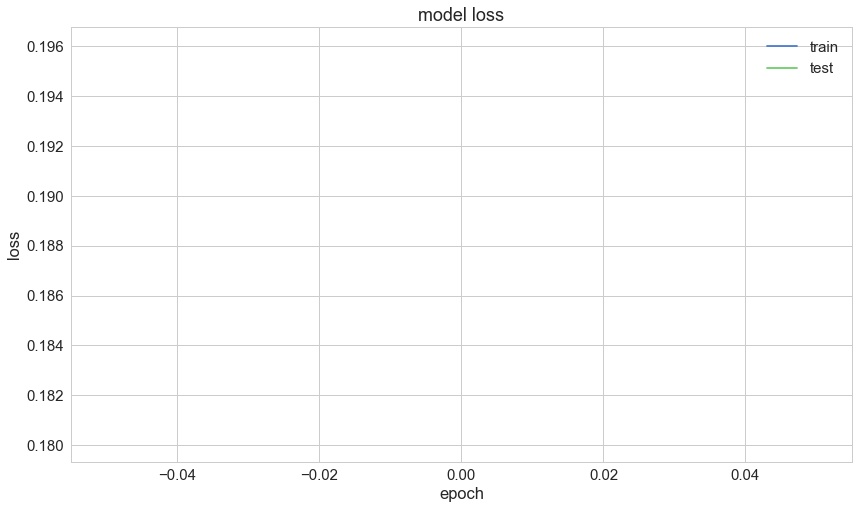

In [18]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
autoencoder = load_model('model.h5')

In [20]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': labels})
error_df.describe()

,reconstruction_error,true_class
count,286048.000000,286048.000000
mean,0.998921,0.009603
std,0.755053,0.097525
min,0.144625,0.000000
25%,0.558478,0.000000
50%,0.806814,0.000000
75%,1.190125,0.000000
max,21.887713,1.000000


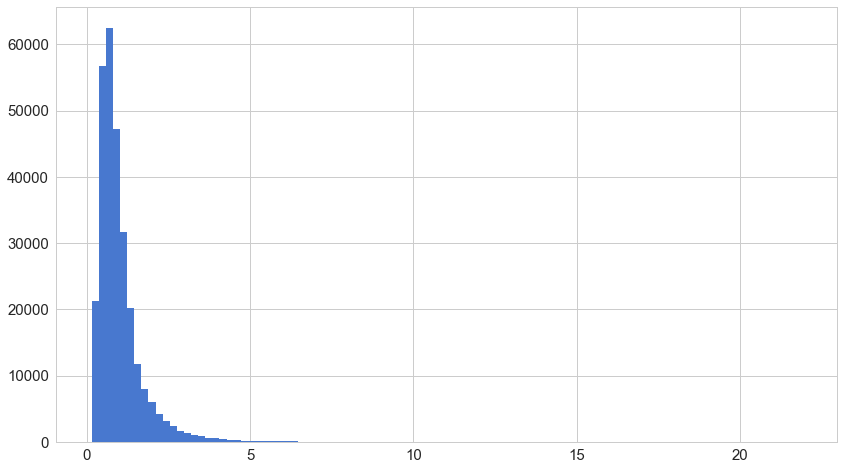

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=100)

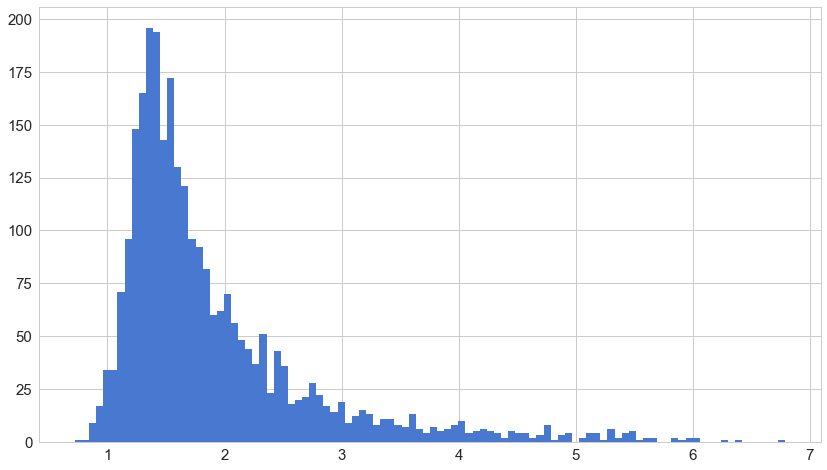

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=100)

In [23]:
threshold = 0.998921

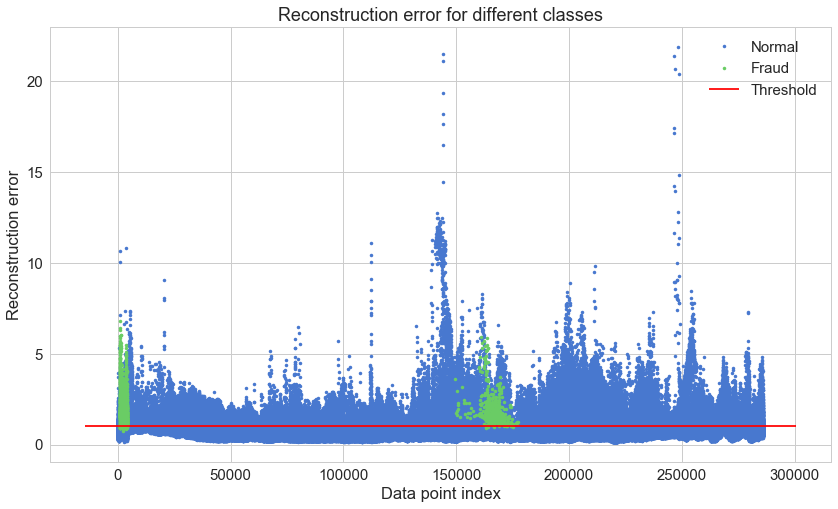

In [24]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

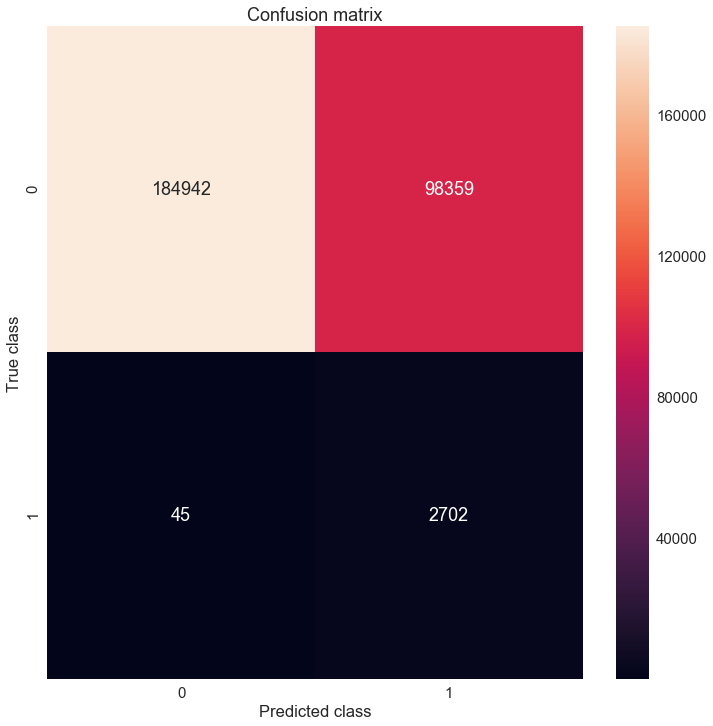

In [25]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()